In [1]:
from IPython.display import clear_output

import numpy as np
import matplotlib.pyplot as plt

from reaktoro_transport.mesh import XDMFMesh, MarkedRectangleMesh

from dolfin import plot

%matplotlib inline
plt.rcParams.update({'font.size': 18})
plt.rc('text', usetex = True)
plt.rc('font', **{'family' : "sans-serif"})

In [2]:
class MeshFactory(XDMFMesh, MarkedRectangleMesh):
    def __init__(self):
        super().__init__()

    def get_mesh_and_markers(self):
        try:
            self.read_mesh('../01_mesh_generation/pore_mesh.xdmf')
        except:
            raise Exception('filepath does not contain mesh.')

        self.set_bottom_left_coordinates(coord_x = 0.0, coord_y = 0.0)
        self.set_top_right_coordinates(coord_x = 5.0, coord_y = 5.0)
        
        #self.refine_mesh()
        self.boundary_markers, self.marker_dict = self.generate_boundary_markers()
        domain_markers = self.generate_domain_markers()

        return self.mesh, self.boundary_markers, domain_markers

    def refine_mesh(self):
        cell_markers = MeshFunction('bool', self.mesh, dim=self.mesh.geometric_dimension())
        cell_markers.set_all(1)
        
        self.mesh = refine(self.mesh, cell_markers)

In [3]:
factory = MeshFactory()
mesh, boundary_markers, domain_markers = factory.get_mesh_and_markers()

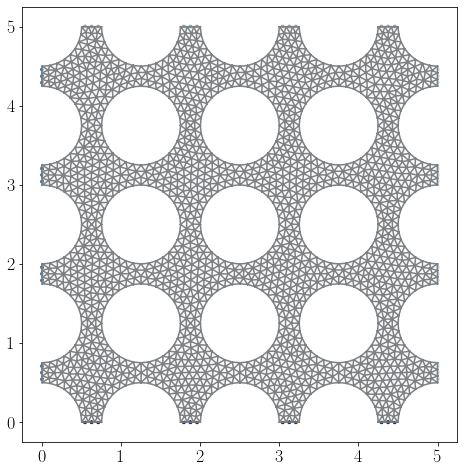

In [4]:
# Plot mesh
fig, ax = plt.subplots(1, 1, figsize=(8,8))
plot(mesh)
factory.plot_boundary_markers(ax, s=10)
plt.show()

In [4]:
flow_problem = StokesFlowUzawa()

flow_problem.set_mesh(mesh_xdmf)
flow_problem.set_boundary_markers(boundary_markers)
flow_problem.set_domain_markers(domain_markers)

In [5]:
# Defining the inlet and noslip boundary markers
b_dict = {'inlet': [2, 3, 4], 'noslip': [10], 'velocity_bc': []}
flow_problem.mark_flow_boundary(**b_dict)

In [6]:
flow_problem.set_velocity_vector_fe_space('CR', 1)
flow_problem.set_pressure_fe_space('DG', 0)

flow_problem.set_pressure_ic(Expression('0.0', degree=0))

p_dirichlet_list = [Constant(1.0), Constant(1.0), Constant(0.0)]
flow_problem.set_form_and_pressure_bc(p_dirichlet_list)
flow_problem.set_velocity_bc(velocity_bc_val=[])

flow_problem.set_uzawa_parameters(r_val=1e3, omega_val=1e3)
flow_problem.assemble_matrix()
flow_problem.set_solver()

In [7]:
%%time 
velocity, pressure = flow_problem.solve_flow(target_residual=1e-10, max_steps=10)

clear_output()

  1 KSP preconditioned resid norm 1.484623259726e-20 true resid norm 5.511241591580e-17 ||r(i)||/||b|| 6.152265569345e-17
  0 KSP preconditioned resid norm 2.767813481897e-06 true resid norm 4.718565952676e-08 ||r(i)||/||b|| 5.267391924816e-08
  1 KSP preconditioned resid norm 1.881914731151e-21 true resid norm 5.408165552911e-17 ||r(i)||/||b|| 6.037200252614e-17
CPU times: user 2.17 s, sys: 1.4 s, total: 3.57 s
Wall time: 862 ms


In [8]:
# Check residual
flow_problem.get_residual()

4.894006839947078e-11

In [9]:
# Output to file
flow_problem.quick_save(file_name='pv_output_fluid_mesh')

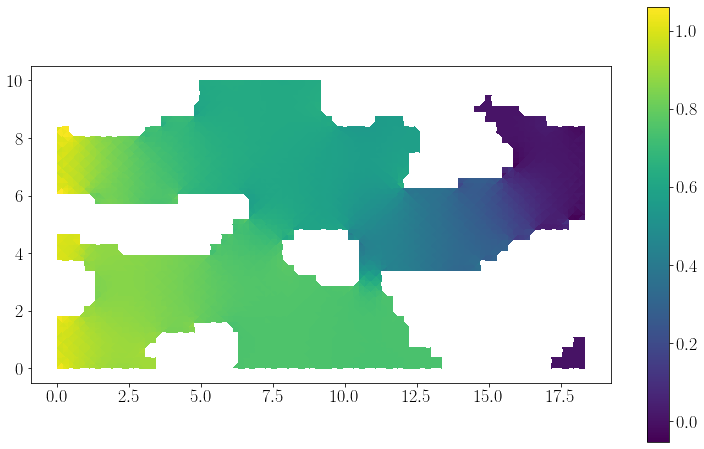

In [10]:
fig = plt.figure(figsize=(13,8))
cb = plot(pressure)
fig.colorbar(cb)
plt.show()